## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import make_regression, make_classification, load_digits
from sklearn.model_selection import train_test_split

from sparse_model import MyModel, SparseLinear
from sparse_model import convert_to_sparse
from train import train_one_model, valid_model
from pruning import evaluate_sensitivity, do_pruning
from speed_metrics import inference_time_over_params, get_number_of_params
from speed_metrics import get_avg_inference_time


SEED = 8642
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device('cpu')  
# mps_deivce = torch.device('mps')
device

device(type='cpu')

In [2]:
layer_sizes = {
    'small': [10, 20, 40, 20, 1], 
    'base': [64, 100, 50, 1],
    'large': [64, 200, 100, 1]
}

metric_table = {
    'basic': [],
    'SensitivityBased': [],
    'L1': []
}

## Speed tests

### sklearn regression

#### basic model

In [3]:
def get_regression_dataloaders(layers, n_samples=1000, batch_size=32):
    X, y = make_regression(n_samples=n_samples, n_features=layers[0], 
                           n_informative=layers[0], random_state=SEED)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    train_dataset, test_dataset = train_test_split(list(zip(X, y)), test_size=0.2, random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [7]:
layers = layer_sizes['small']

train_loader, val_loader = get_regression_dataloaders(layers)
criterion = nn.MSELoss()
model = MyModel(layers).to(device)
get_number_of_params(model)

1901

Training Progress: 100%|██████████| 500/500 [00:08<00:00, 60.62it/s]


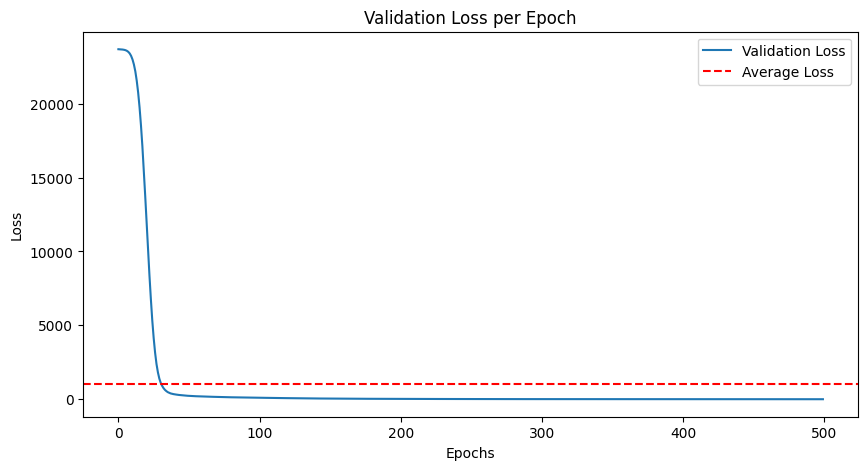

1.6638199942452567

In [8]:
train_one_model(model, train_loader, val_loader, device, 
                epochs=500, criterion=criterion, patience=50)

In [9]:
valid_model(model, val_loader, criterion, device)

1.6638199942452567

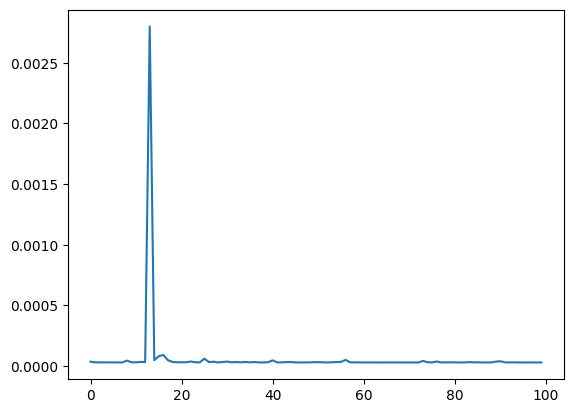

In [10]:
itop = [inference_time_over_params(model, val_loader, device)
        for _ in range(100)]
metric_table['basic'].append(np.mean(itop))
plt.plot(itop)

#### sensitivity pruning

In [11]:
sensitivity = evaluate_sensitivity(model, val_loader, criterion, device)
pruned_model_sens = do_pruning(model, pruning_type="SensitivityBased", sensitivity=sensitivity, amount=0.2, logs=False).to(device)
valid_model(pruned_model_sens, val_loader, criterion, device)

3328.852957589286

Training Progress: 100%|██████████| 1000/1000 [00:21<00:00, 46.92it/s]


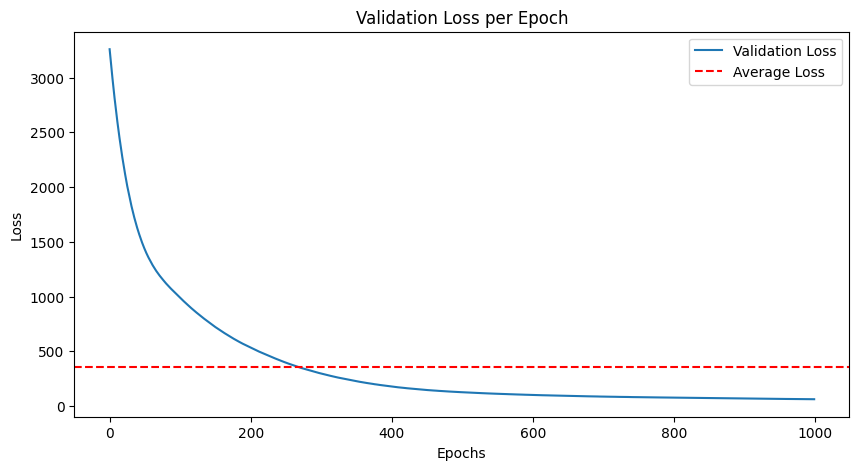

61.927259172712056

In [12]:
sparse_model_sens = convert_to_sparse(pruned_model_sens)
train_one_model(sparse_model_sens, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

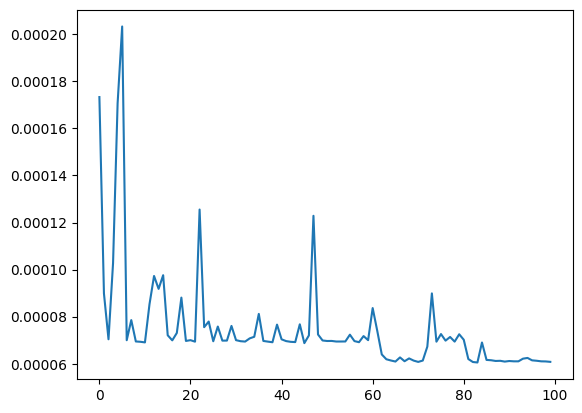

In [13]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['SensitivityBased'].append(np.mean(itop))
plt.plot(itop)

#### l1 pruning

In [14]:
pruned_model_l1 = do_pruning(model, pruning_type="L1", amount=0.2, logs=False).to(device)
valid_model(pruned_model_l1, val_loader, criterion, device)

192.06065150669642

Training Progress: 100%|██████████| 1000/1000 [00:19<00:00, 50.20it/s]


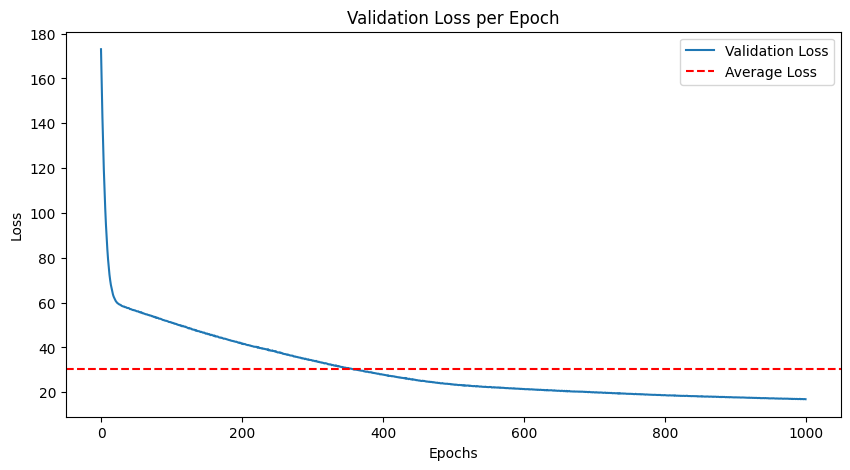

16.914306640625

In [15]:
sparse_model_l1 = convert_to_sparse(pruned_model_l1)
train_one_model(sparse_model_l1, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

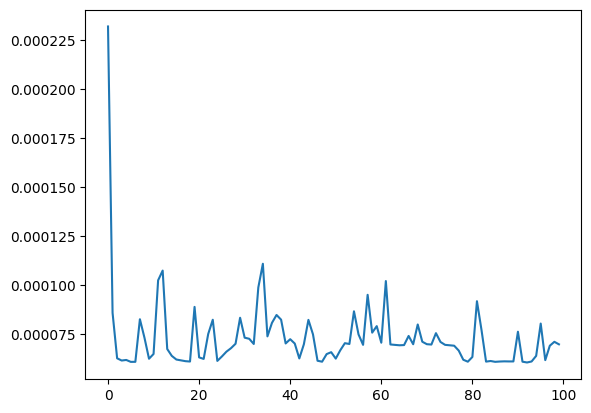

In [16]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['L1'].append(np.mean(itop))
plt.plot(itop)

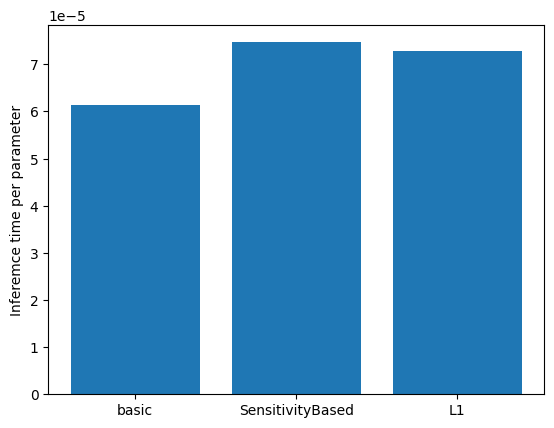

In [17]:
plt.bar(x=list(metric_table.keys()), height=np.array(list(metric_table.values())).flatten())
# plt.xlabel('Model type')
plt.ylabel('Inferemce time per parameter')
plt.show()

### sklearn classification

#### basic model

In [18]:
def get_classification_dataloaders(layers, n_samples=1000, batch_size=32):
    X, y = make_classification(n_samples=n_samples, n_features=layers[0], random_state=SEED)
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()
    train_dataset, test_dataset = train_test_split(list(zip(X, y)), test_size=0.2, random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [19]:
layers = layer_sizes['base']

train_loader, val_loader = get_classification_dataloaders(layers)
criterion = nn.CrossEntropyLoss()
model = MyModel(layers).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
get_number_of_params(model)

11601

Training Progress:  74%|███████▍  | 370/500 [00:03<00:01, 93.31it/s] 


Early stopping triggered


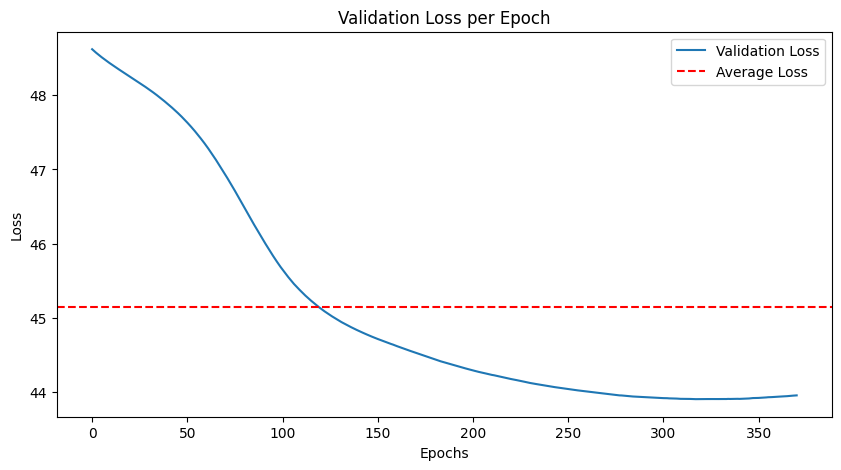

43.898345947265625

In [20]:
train_one_model(model, train_loader, val_loader, device, 
                epochs=500, criterion=criterion, 
                patience=50, optimizer=optimizer)

In [21]:
valid_model(model, val_loader, criterion, device)

43.950182233537944

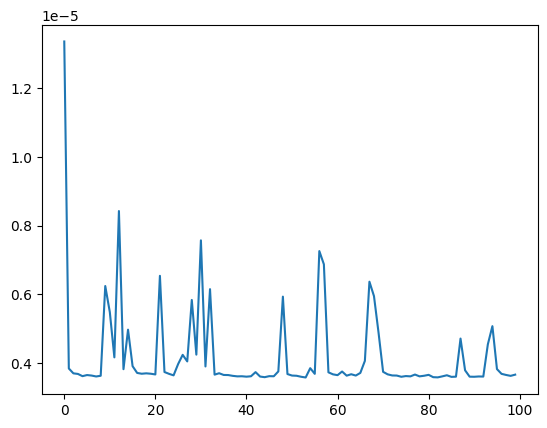

In [22]:
itop = [inference_time_over_params(model, val_loader, device)
        for _ in range(100)]
metric_table['basic'].append(np.mean(itop))
plt.plot(itop)

#### sensitivity pruning

In [23]:
sensitivity = evaluate_sensitivity(model, val_loader, criterion, device)
pruned_model_sens = do_pruning(model, pruning_type="SensitivityBased", sensitivity=sensitivity, amount=0.2, logs=False).to(device)
valid_model(pruned_model_sens, val_loader, criterion, device)

43.94309779575893

Training Progress:  27%|██▋       | 272/1000 [00:05<00:14, 51.28it/s]


Early stopping triggered


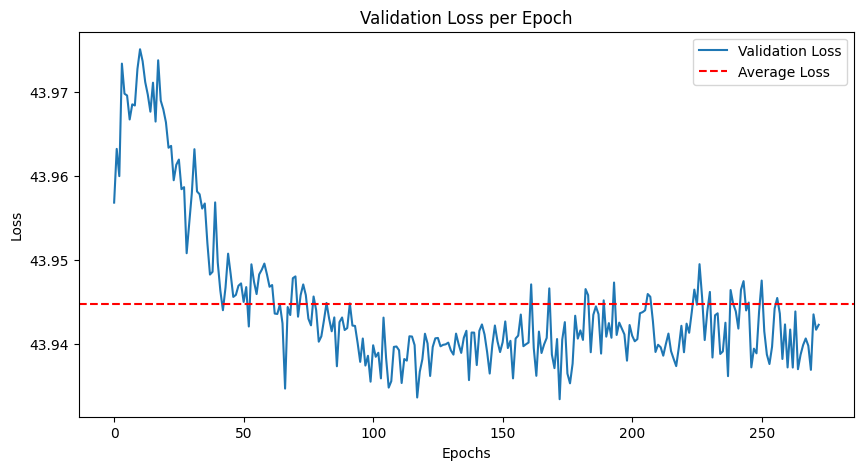

43.933380126953125

In [24]:
sparse_model_sens = convert_to_sparse(pruned_model_sens)
train_one_model(sparse_model_sens, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

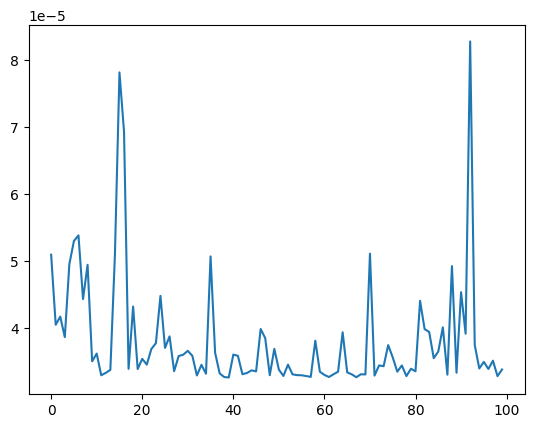

In [25]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['SensitivityBased'].append(np.mean(itop))
plt.plot(itop)

#### l1 pruning

In [26]:
pruned_model_l1 = do_pruning(model, pruning_type="L1", amount=0.2, logs=False).to(device)
valid_model(pruned_model_l1, val_loader, criterion, device)

43.944492885044646

Training Progress:  12%|█▏        | 118/1000 [00:02<00:16, 53.42it/s]


Early stopping triggered


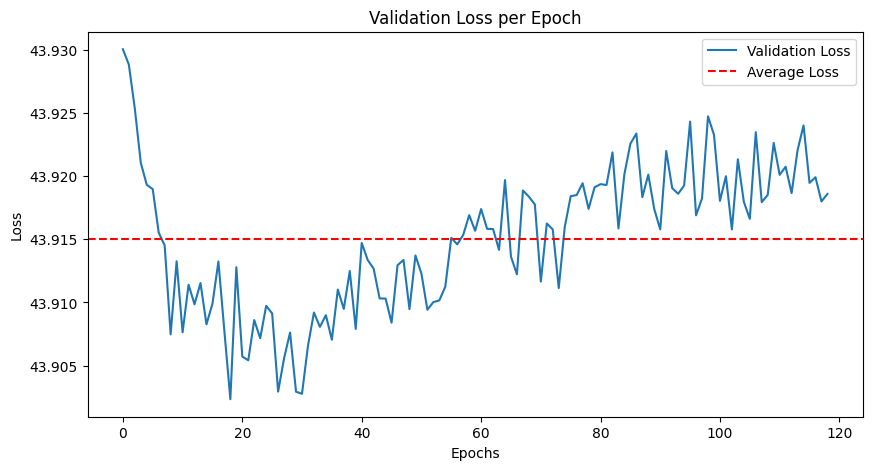

43.902335030691965

In [27]:
sparse_model_l1 = convert_to_sparse(pruned_model_l1)
train_one_model(sparse_model_l1, train_loader, val_loader, device, 
                epochs=1000, criterion=criterion, patience=100)

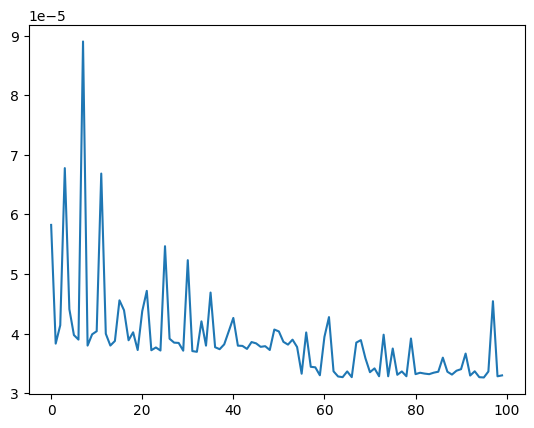

In [28]:
itop = [inference_time_over_params(sparse_model_sens, val_loader, device)
        for _ in range(100)]
metric_table['L1'].append(np.mean(itop))
plt.plot(itop)

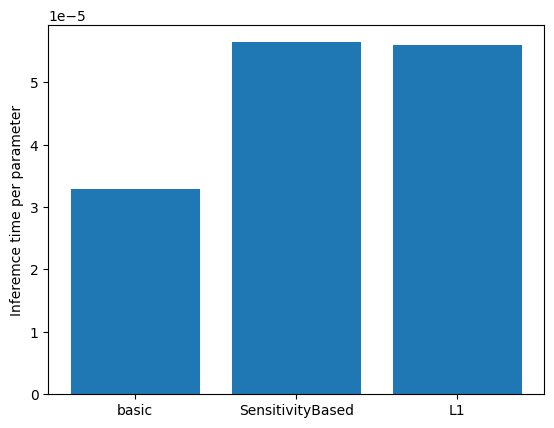

In [29]:
plt.bar(x=list(metric_table.keys()), height=np.array(list(metric_table.values())).mean(axis=1))
# plt.xlabel('Model type')
plt.ylabel('Inferemce time per parameter')
plt.show()